## Avaliação em holdouts - Movielens

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
## Read Data

In [4]:
# importa dataset 'palco playlists'
data = pd.read_csv('output/movielens_dump/sampled_movielens.csv')

In [5]:
user_col = 'UserID'
item_col = 'ItemID'

In [6]:
data.shape, data[user_col].nunique(), data[item_col].nunique()

((50742, 7), 1427, 2492)

In [7]:
data[[user_col, item_col]].duplicated().sum()

0

In [8]:
data.shape

(50742, 7)

In [9]:
data.head()

,UserID,ItemID,Timestamp,date2,year,month,date
0,4448,902,965087178,2000-07-31 23:46:18,2000,7,2000-07-01 00:00:00
1,4448,3793,965087267,2000-07-31 23:47:47,2000,7,2000-07-01 00:00:00
2,4448,3751,965087267,2000-07-31 23:47:47,2000,7,2000-07-01 00:00:00
3,4448,3578,965087349,2000-07-31 23:49:09,2000,7,2000-07-01 00:00:00
4,4448,3481,965087470,2000-07-31 23:51:10,2000,7,2000-07-01 00:00:00


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50742 entries, 0 to 50741
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UserID     50742 non-null  int64 
 1   ItemID     50742 non-null  int64 
 2   Timestamp  50742 non-null  int64 
 3   date2      50742 non-null  object
 4   year       50742 non-null  int64 
 5   month      50742 non-null  int64 
 6   date       50742 non-null  object
dtypes: int64(5), object(2)
memory usage: 2.7+ MB


### Convert timestamp

In [11]:
data

,UserID,ItemID,Timestamp,date2,year,month,date
0,4448,902,965087178,2000-07-31 23:46:18,2000,7,2000-07-01 00:00:00
1,4448,3793,965087267,2000-07-31 23:47:47,2000,7,2000-07-01 00:00:00
2,4448,3751,965087267,2000-07-31 23:47:47,2000,7,2000-07-01 00:00:00
3,4448,3578,965087349,2000-07-31 23:49:09,2000,7,2000-07-01 00:00:00
4,4448,3481,965087470,2000-07-31 23:51:10,2000,7,2000-07-01 00:00:00
...,...,...,...,...,...,...,...
50737,5612,2581,959174063,2000-05-24 13:14:23,2000,5,2000-05-01 00:00:00
50738,5612,2961,959174130,2000-05-24 13:15:30,2000,5,2000-05-01 00:00:00
50739,5612,858,959174918,2000-05-24 13:28:38,2000,5,2000-05-01 00:00:00
50740,5612,3362,959174939,2000-05-24 13:28:59,2000,5,2000-05-01 00:00:00


In [12]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %X'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 518 ms, sys: 2.93 ms, total: 521 ms
Wall time: 520 ms


CPU times: user 56.9 ms, sys: 418 µs, total: 57.4 ms
Wall time: 54.9 ms


Text(0.5, 1.0, 'interactions per month')

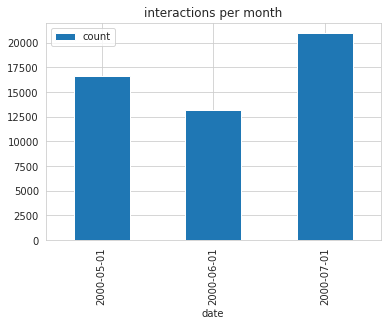

In [13]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [14]:
# user_presence_df = pd.read_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv')
# user_month_interactions = pd.read_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv')
# frequent_users_month = joblib.load('output/amazon_digmusic_dump/sample_frequent_users_month.joblib')

___
## Experiments using months

In [15]:
data.shape

(50742, 7)

In [16]:
data['timestamp'] = data['Timestamp']

In [17]:
%%time
# 1min 29s
buckets, holdouts = getBucketsHoldouts(
    data=data,# data[ data['date'].dt.month==1 ],# 
    user_col=user_col,
    item_col=item_col,
    frequent_users=data[user_col].unique(),# frequent_users_month, # for every user in holdout: data['user_id'].unique()
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 0
common interactions between holdout 2 and all buckets: 0
common interactions between holdout 3 and all buckets: 0
Converting to ImplicitData. . .
Done!
CPU times: user 2.59 s, sys: 19.2 ms, total: 2.61 s
Wall time: 2.61 s


In [18]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

50742

In [19]:
joblib.dump(buckets, 'output/movielens_dump/sample_buckets.joblib')
joblib.dump(holdouts, 'output/movielens_dump/sample_holdouts.joblib')

['output/movielens_dump/sample_holdouts.joblib']

In [20]:
buckets = joblib.load('output/movielens_dump/sample_buckets.joblib')
holdouts = joblib.load('output/movielens_dump/sample_holdouts.joblib')

In [21]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(20313, 697, 2025), (12706, 454, 1748), (16160, 454, 1896)]

In [22]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(664, 664, 457), (442, 442, 329), (457, 457, 340)]

### ISGD

In [40]:
%%time
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
#     num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization] # , num_nodes
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg = hp # , nn
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
prop = 0.1 # 0.05
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=1 )
len(grid), len(results), max(results) # (243, 243, 0.0026656511805026656)

0.0 %
0.25 %
0.5 %
0.75 %
1.0 %
1.25 %
1.5 %
1.75 %
2.0 %
2.25 %
2.5 %
2.75 %
3.0 %
3.25 %
3.5 %
3.75 %
4.0 %
4.25 %
4.5 %
4.75 %
5.0 %
5.25 %
5.5 %
5.75 %
6.0 %
6.25 %
6.5 %
6.75 %
7.0 %
7.25 %
7.5 %
7.75 %
8.0 %
8.25 %
8.5 %
8.75 %
9.0 %
9.25 %
9.5 %
9.75 %
10.0 %
10.25 %
10.5 %
10.75 %
11.0 %
11.25 %
11.5 %
11.75 %
12.0 %
12.25 %
12.5 %
12.75 %
13.0 %
13.25 %
13.5 %
13.75 %
14.0 %
14.25 %
14.5 %
14.75 %
15.0 %
15.25 %
15.5 %
15.75 %
16.0 %
16.25 %
16.5 %
16.75 %
17.0 %
17.25 %
17.5 %
17.75 %
18.0 %
18.25 %
18.5 %
18.75 %
19.0 %
19.25 %
19.5 %
19.75 %
20.0 %
20.25 %
20.5 %
20.75 %
21.0 %
21.25 %
21.5 %
21.75 %
22.0 %
22.25 %
22.5 %
22.75 %
23.0 %
23.25 %
23.5 %
23.75 %
24.0 %
24.25 %
24.5 %
24.75 %
25.0 %
25.25 %
25.5 %
25.75 %
26.0 %
26.25 %
26.5 %
26.75 %
27.0 %
27.25 %
27.5 %
27.75 %
28.0 %
28.25 %
28.5 %
28.75 %
29.0 %
29.25 %
29.5 %
29.75 %
30.0 %
30.25 %
30.5 %
30.75 %
31.0 %
31.25 %
31.5 %
31.75 %
32.0 %
32.25 %
32.5 %
32.75 %
33.0 %
33.25 %
33.5 %
33.75 %
34.0 %
34.25 %
34.5 

(400, 400, 0.09270058314900463)

In [58]:
print( grid[ np.argmax( results ) ] ) # from 6 months (150, 2, 0.5, 0.5) # from 3 months (150, 8, 0.25, 0.25)
num_factors, num_iter, learn_rate, regularization = (150, 2, 0.5, 0.5) #grid[ np.argmax( results ) ]

(150, 8, 0.25, 0.25)


In [59]:
# # define hyperparameters
# num_factors = 160
# num_iter = 8
# learn_rate = 0.1
# regularization = 0.4
# num_nodes = 8

In [60]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [61]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [62]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 353
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 420
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 359
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 1min 4s, sys: 1min 14s, total: 2min 19s
Wall time: 32.3 s


In [64]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/movielens_dump/sample_movielens month_bucket ISGD results.csv', index=False)

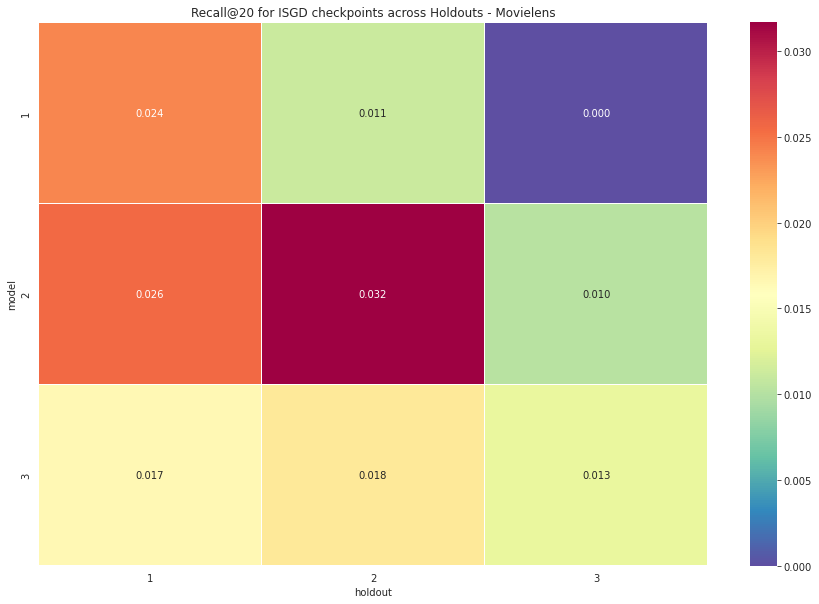

In [66]:
recall_heatmap(df,
    round_point=3,
    title='Recall@20 for ISGD checkpoints across Holdouts - Movielens',
    filepath='images/heatmaps/movielens_dump/sample_movielens month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [67]:
arecall = avg_recall(df)
arecall

0.022966565510534668

In [68]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.00150602409638554, -0.010552390557705935], -0.004523183230660198)

In [69]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.007146678896277611

In [70]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/movielens_dump/sample_movielens month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/movielens_dump/sample_movielens month_bucket ISGD eval time.joblib')

['output/movielens_dump/sample_movielens month_bucket ISGD eval time.joblib']

In [1]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [2]:
df = pd.read_csv('output/movielens_dump/sample_movielens month_bucket ISGD results.csv')

In [8]:
avg_recall(df).round(4)

0.023

In [9]:
BWT, diff = compute_BWT(df)
BWT.round(5)

-0.00653

In [10]:
compute_FWT(df).round(5)

0.00715